# US Childcare: A Short Study

## Context
Childcare in the United States is a critical service that supports the economy by enabling parents to work. However, the cost and availability of childcare vary widely by location and demographic factors, potentially affecting employment rates and economic opportunities. With this study, my aim is to dive deep into these variations to uncover patterns that could inform policy and decision-making.

## Objectives
The primary objectives of this study are:
- To explore the relationship between childcare costs and employment rates.
- To assess the affordability of childcare across different counties.
- To determine if demographic patterns exist in childcare costs.
- To provide insights that could guide policy and potentially lead to more equitable childcare services.

## Processes
To accomplish these objectives, I implemented several data analysis processes:
- Performed exploratory data analysis (EDA) to understand the data's structure and to identify any missingness or outliers.
- Utilized regression analysis to investigate the impact of childcare costs on labor force participation.
- Conducted clustering to identify similar counties in terms of demographics and childcare costs.
- Applied ANOVA and post-hoc Tukey tests to assess statistical differences in childcare costs across clusters.

Data was processed using Python, with libraries such as Pandas for data manipulation, Scikit-learn for machine learning tasks, and Statsmodels for statistical tests.


In [1]:
#Imports
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Set display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
# Function to read files and handle exceptions
def read_file(filename):
    try:
        df = pd.read_csv(filename, low_memory=False)
        return df
    except FileNotFoundError:
        print('File not found. Please check the file path and try again.')
    except Exception as e:
        print(f'An error occurred: {e}')        

# Reading the datasets
childcare_costs_df = read_file('Datasets/childcare_costs.csv')
counties_df = read_file('Datasets/counties.csv')


# Displaying the first few rows of the dataframes
display(childcare_costs_df.head(5))
display(counties_df.head(5))

,county_fips_code,study_year,unr_16,funr_16,munr_16,unr_20to64,funr_20to64,munr_20to64,flfpr_20to64,flfpr_20to64_under6,flfpr_20to64_6to17,flfpr_20to64_under6_6to17,mlfpr_20to64,pr_f,pr_p,mhi_2018,me_2018,fme_2018,mme_2018,total_pop,one_race,one_race_w,one_race_b,one_race_i,one_race_a,one_race_h,one_race_other,two_races,hispanic,households,h_under6_both_work,h_under6_f_work,h_under6_m_work,h_under6_single_m,h_6to17_both_work,h_6to17_fwork,h_6to17_mwork,h_6to17_single_m,emp_m,memp_m,femp_m,emp_service,memp_service,femp_service,emp_sales,memp_sales,femp_sales,emp_n,memp_n,femp_n,emp_p,memp_p,femp_p,mcsa,mfccsa,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool
0,1001,2008,5.42,4.41,6.32,4.6,3.5,5.6,68.9,66.9,79.59,60.81,84.0,8.5,11.5,58462.55,32710.60,25156.25,41436.80,49744,98.1,78.9,17.7,0.4,0.4,0.0,0.7,1.9,1.8,18373,1543,970,22,995.0,4900,1308,114,1966.0,27.40,24.41,30.68,17.06,15.53,18.75,29.11,15.97,43.52,13.21,22.54,2.99,13.22,21.55,4.07,80.92,81.40,104.95,104.95,85.92,83.45,83.45,81.40
1,1001,2009,5.93,5.72,6.11,4.8,4.6,5.0,70.8,63.7,78.41,59.91,86.2,7.5,10.3,60211.71,34688.16,26852.67,43865.64,49584,98.6,79.1,17.9,0.4,0.6,0.0,0.7,1.4,2.0,18288,1475,964,16,1099.0,5028,1519,92,2305.0,29.54,26.07,33.40,15.81,14.16,17.64,28.75,17.51,41.25,11.89,20.30,2.52,14.02,21.96,5.19,83.42,85.68,105.11,105.11,87.59,87.39,87.39,85.68
2,1001,2010,6.21,5.57,6.78,5.1,4.6,5.6,71.3,67.0,78.15,59.71,85.8,7.5,10.6,61775.80,34740.84,27391.08,46155.24,53155,98.5,79.1,17.9,0.3,0.7,0.0,0.6,1.5,2.3,19718,1569,1009,16,1110.0,5472,1541,113,2377.0,29.33,25.94,33.06,16.92,15.09,18.93,29.07,17.82,41.43,11.57,19.86,2.45,13.11,21.28,4.13,85.92,89.96,105.28,105.28,89.26,91.33,91.33,89.96
3,1001,2011,7.55,8.13,7.03,6.2,6.3,6.1,70.2,66.5,77.62,59.31,85.7,7.4,10.9,60366.88,34564.32,26727.68,45333.12,53944,98.5,78.9,18.1,0.2,0.7,0.0,0.5,1.5,2.4,19998,1695,1060,106,1030.0,5065,1965,246,2299.0,31.17,26.97,35.96,16.18,14.21,18.42,27.56,17.74,38.76,10.72,18.28,2.09,14.38,22.80,4.77,88.43,94.25,105.45,105.45,90.93,95.28,95.28,94.25
4,1001,2012,8.60,8.88,8.29,6.7,6.4,7.0,70.6,67.1,76.31,58.30,85.7,7.4,11.6,59150.30,34327.70,27967.50,44276.10,54590,98.5,78.9,18.1,0.3,0.8,0.0,0.4,1.5,2.4,19934,1714,938,120,1095.0,4608,1963,284,2644.0,32.13,28.59,36.09,16.09,14.71,17.63,28.39,17.79,40.26,9.02,16.03,1.19,14.37,22.88,4.84,90.93,98.53,105.61,105.61,92.60,99.22,99.22,98.53


,county_fips_code,county_name,state_name,state_abbreviation
0,1001,Autauga County,Alabama,AL
1,1003,Baldwin County,Alabama,AL
2,1005,Barbour County,Alabama,AL
3,1007,Bibb County,Alabama,AL
4,1009,Blount County,Alabama,AL


In [3]:
#Merging the childcare cost and county dataframes
merged_df = pd.merge(childcare_costs_df, counties_df, on='county_fips_code', how='left')
merged_df.head()

,county_fips_code,study_year,unr_16,funr_16,munr_16,unr_20to64,funr_20to64,munr_20to64,flfpr_20to64,flfpr_20to64_under6,flfpr_20to64_6to17,flfpr_20to64_under6_6to17,mlfpr_20to64,pr_f,pr_p,mhi_2018,me_2018,fme_2018,mme_2018,total_pop,one_race,one_race_w,one_race_b,one_race_i,one_race_a,one_race_h,one_race_other,two_races,hispanic,households,h_under6_both_work,h_under6_f_work,h_under6_m_work,h_under6_single_m,h_6to17_both_work,h_6to17_fwork,h_6to17_mwork,h_6to17_single_m,emp_m,memp_m,femp_m,emp_service,memp_service,femp_service,emp_sales,memp_sales,femp_sales,emp_n,memp_n,femp_n,emp_p,memp_p,femp_p,mcsa,mfccsa,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool,county_name,state_name,state_abbreviation
0,1001,2008,5.42,4.41,6.32,4.6,3.5,5.6,68.9,66.9,79.59,60.81,84.0,8.5,11.5,58462.55,32710.60,25156.25,41436.80,49744,98.1,78.9,17.7,0.4,0.4,0.0,0.7,1.9,1.8,18373,1543,970,22,995.0,4900,1308,114,1966.0,27.40,24.41,30.68,17.06,15.53,18.75,29.11,15.97,43.52,13.21,22.54,2.99,13.22,21.55,4.07,80.92,81.40,104.95,104.95,85.92,83.45,83.45,81.40,Autauga County,Alabama,AL
1,1001,2009,5.93,5.72,6.11,4.8,4.6,5.0,70.8,63.7,78.41,59.91,86.2,7.5,10.3,60211.71,34688.16,26852.67,43865.64,49584,98.6,79.1,17.9,0.4,0.6,0.0,0.7,1.4,2.0,18288,1475,964,16,1099.0,5028,1519,92,2305.0,29.54,26.07,33.40,15.81,14.16,17.64,28.75,17.51,41.25,11.89,20.30,2.52,14.02,21.96,5.19,83.42,85.68,105.11,105.11,87.59,87.39,87.39,85.68,Autauga County,Alabama,AL
2,1001,2010,6.21,5.57,6.78,5.1,4.6,5.6,71.3,67.0,78.15,59.71,85.8,7.5,10.6,61775.80,34740.84,27391.08,46155.24,53155,98.5,79.1,17.9,0.3,0.7,0.0,0.6,1.5,2.3,19718,1569,1009,16,1110.0,5472,1541,113,2377.0,29.33,25.94,33.06,16.92,15.09,18.93,29.07,17.82,41.43,11.57,19.86,2.45,13.11,21.28,4.13,85.92,89.96,105.28,105.28,89.26,91.33,91.33,89.96,Autauga County,Alabama,AL
3,1001,2011,7.55,8.13,7.03,6.2,6.3,6.1,70.2,66.5,77.62,59.31,85.7,7.4,10.9,60366.88,34564.32,26727.68,45333.12,53944,98.5,78.9,18.1,0.2,0.7,0.0,0.5,1.5,2.4,19998,1695,1060,106,1030.0,5065,1965,246,2299.0,31.17,26.97,35.96,16.18,14.21,18.42,27.56,17.74,38.76,10.72,18.28,2.09,14.38,22.80,4.77,88.43,94.25,105.45,105.45,90.93,95.28,95.28,94.25,Autauga County,Alabama,AL
4,1001,2012,8.60,8.88,8.29,6.7,6.4,7.0,70.6,67.1,76.31,58.30,85.7,7.4,11.6,59150.30,34327.70,27967.50,44276.10,54590,98.5,78.9,18.1,0.3,0.8,0.0,0.4,1.5,2.4,19934,1714,938,120,1095.0,4608,1963,284,2644.0,32.13,28.59,36.09,16.09,14.71,17.63,28.39,17.79,40.26,9.02,16.03,1.19,14.37,22.88,4.84,90.93,98.53,105.61,105.61,92.60,99.22,99.22,98.53,Autauga County,Alabama,AL


In [4]:
# Utilizing the .info(), .isnull().sum(), and .describe() methods to obtain an overview of the dataframe
# These methods provide information on column data types, non-null value count, and basic statistics
# This helps in understanding the structure and any missing values in the data
display(merged_df.info())
display(merged_df.isnull().sum())
display(merged_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34567 entries, 0 to 34566
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   county_fips_code           34567 non-null  int64  
 1   study_year                 34567 non-null  int64  
 2   unr_16                     34567 non-null  float64
 3   funr_16                    34567 non-null  float64
 4   munr_16                    34567 non-null  float64
 5   unr_20to64                 34567 non-null  float64
 6   funr_20to64                34567 non-null  float64
 7   munr_20to64                34567 non-null  float64
 8   flfpr_20to64               34567 non-null  float64
 9   flfpr_20to64_under6        34567 non-null  float64
 10  flfpr_20to64_6to17         34567 non-null  float64
 11  flfpr_20to64_under6_6to17  34567 non-null  float64
 12  mlfpr_20to64               34567 non-null  float64
 13  pr_f                       34567 non-null  flo

None

county_fips_code                 0
study_year                       0
unr_16                           0
funr_16                          0
munr_16                          0
unr_20to64                       0
funr_20to64                      0
munr_20to64                      0
flfpr_20to64                     0
flfpr_20to64_under6              0
flfpr_20to64_6to17               0
flfpr_20to64_under6_6to17        0
mlfpr_20to64                     0
pr_f                             0
pr_p                             0
mhi_2018                         0
me_2018                          0
fme_2018                         0
mme_2018                         0
total_pop                        0
one_race                         0
one_race_w                       0
one_race_b                       0
one_race_i                       0
one_race_a                       0
one_race_h                       0
one_race_other                   0
two_races                        0
hispanic            

,county_fips_code,study_year,unr_16,funr_16,munr_16,unr_20to64,funr_20to64,munr_20to64,flfpr_20to64,flfpr_20to64_under6,flfpr_20to64_6to17,flfpr_20to64_under6_6to17,mlfpr_20to64,pr_f,pr_p,mhi_2018,me_2018,fme_2018,mme_2018,total_pop,one_race,one_race_w,one_race_b,one_race_i,one_race_a,one_race_h,one_race_other,two_races,hispanic,households,h_under6_both_work,h_under6_f_work,h_under6_m_work,h_under6_single_m,h_6to17_both_work,h_6to17_fwork,h_6to17_mwork,h_6to17_single_m,emp_m,memp_m,femp_m,emp_service,memp_service,femp_service,emp_sales,memp_sales,femp_sales,emp_n,memp_n,femp_n,emp_p,memp_p,femp_p,mcsa,mfccsa,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool
count,34567.000000,34567.000000,34567.000000,34567.00000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,3.456700e+04,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,3.456700e+04,34567.000000,34567.000000,34567.000000,34565.000000,34567.000000,34567.000000,34567.000000,34565.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,34567.000000,23593.000000,23383.000000,23593.000000,23593.000000,23593.000000,23383.000000,23383.000000,23383.000000
mean,30388.132786,2012.999711,7.465902,7.02902,7.860291,6.900073,6.482007,7.275457,70.086125,68.821409,78.824106,66.940759,78.637814,11.739125,16.038131,50446.777363,29404.295539,23475.169710,35997.433918,9.914222e+04,97.922863,83.636247,8.971213,1.895634,1.216209,0.082101,2.117914,2.077146,8.401054,3.686299e+04,2791.610004,1821.628808,141.109064,1992.249964,6480.568548,2874.374374,390.113056,3924.511558,30.720191,26.495400,35.509491,17.909716,13.122111,23.424303,22.244044,13.660359,32.062036,13.076182,23.265887,1.369745,16.049861,23.456238,7.634403,101.234253,92.523582,146.051770,130.482768,122.232852,113.421657,106.759749,104.189510
std,15161.015383,3.162232,3.538619,3.56342,4.037657,3.446199,3.477956,3.990758,7.696499,11.758088,8.529813,13.285061,10.802983,5.681003,6.511816,13279.833788,5715.192737,4903.836942,7643.855532,3.177786e+05,1.952523,16.683515,14.510260,7.517786,2.633768,0.593602,3.779858,1.952520,13.284933,1.116470e+05,8709.085062,6740.389344,472.557239,7009.934446,19294.344762,10901.264277,1187.096922,13966.245194,6.503783,8.013214,6.073988,3.602868,4.476415,4.696024,3.352621,3.761803,4.480591,4.257660,6.763236,1.430796,5.935141,7.956927,4.501044,34.552888,27.669904,53.698566,43.775370,38.538323,32.819372,29.982431,28.961701
min,1001.000000,2008.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,33.600000,0.000000,0.000000,0.000000,8.200000,0.000000,0.000000,19841.920000,4947.040000,5019.300000,4238.080000,4.100000e+01,59.500000,3.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.200000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.980000,22.000000,27.730000,21.540000,21.540000,43.080000,43.080000,40.030000
25%,18177.000000,2010.000000,5.100000,4.64000,5.200000,4.600000,4.200000,4.700000,65.100000,62.600000,74.400000,59.800000,74.200000,7.700000,11.400000,41839.215000,25955.055000,20613.100000,31447.505000,1.101450e+04,97.500000,77.000000,0.600000,0.200000,0.200000,0.000000,0.300000,1.100000,1.700000,4.236000e+03,260.000000,146.000000,5.000000,176.000000,685.000000,247.000000,39.000000,351.000000,26.340000,20.945000,31.560000,15.590000,10.270000,20.410000,20.150000,11.210000,29.390000,10.200000,18.680000,0.590000,11.640000,17.610000,4.410000,78.650000,75.000000,108.750000,100.000000,95.880000,90.000000,85.085000,84.255000
50%,29177.000000,2013.000000,7.05000

## Handling Missing Data with K-Nearest Neighbors Imputation

In this analysis, I identified a significant issue with our Childcare dataset: a substantial amount of missing values in critical columns, specifically those representing childcare costs (e.g., `mc_infant`, `mcsa`, `mfccsa`, `mfc_toddler`, etc.). Missing data poses a risk to the integrity of our analysis, as it can lead to biased results and weakens the power of our statistical tests.

Given that childcare costs are pivotal to our study, simply discarding rows with missing data was not an option, as this would eliminate about 32% of our dataset. To address this, I employed the K-Nearest Neighbors (KNN) imputation method.

KNN Imputation is a sophisticated technique that estimates the missing values based on the nearest neighbors found in the multidimensional space of our data. Each missing value is imputed using the mean value from its 'k' nearest neighbors. The 'k' value is a parameter that we can adjust; in our case, I set `k=5`, which indicates that the imputation for each missing value should consider five nearest neighbors.

This approach allows us to retain as much data as possible, providing a richer dataset for our subsequent analyses. It is particularly suitable for our context, where the data points with missing values are not randomly distributed and might have underlying relationships that can be captured by their neighbors.

In [5]:
#Looking for missing rows
rows_with_missing_childcare = merged_df[merged_df[['mcsa', 'mfccsa']].isnull().any(axis=1)]
rows_with_missing_childcare

,county_fips_code,study_year,unr_16,funr_16,munr_16,unr_20to64,funr_20to64,munr_20to64,flfpr_20to64,flfpr_20to64_under6,flfpr_20to64_6to17,flfpr_20to64_under6_6to17,mlfpr_20to64,pr_f,pr_p,mhi_2018,me_2018,fme_2018,mme_2018,total_pop,one_race,one_race_w,one_race_b,one_race_i,one_race_a,one_race_h,one_race_other,two_races,hispanic,households,h_under6_both_work,h_under6_f_work,h_under6_m_work,h_under6_single_m,h_6to17_both_work,h_6to17_fwork,h_6to17_mwork,h_6to17_single_m,emp_m,memp_m,femp_m,emp_service,memp_service,femp_service,emp_sales,memp_sales,femp_sales,emp_n,memp_n,femp_n,emp_p,memp_p,femp_p,mcsa,mfccsa,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool,county_name,state_name,state_abbreviation
737,2013,2008,3.44,5.79,2.51,3.08,5.33,2.21,87.52,70.9,89.44,64.11,96.09,8.18,11.67,63617.36,23401.48,22567.73,24097.10,2930,94.7,15.02,9.17,20.14,45.17,0.3,4.91,5.3,9.84,374,51,17,2,29.0,99,35,16,70.0,16.17,10.92,24.89,12.48,9.31,17.73,10.27,3.04,22.28,16.41,23.95,3.91,44.67,52.78,31.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aleutians East Borough,Alaska,AK
738,2013,2009,4.35,5.96,3.66,4.30,6.00,3.60,92.50,70.2,88.56,63.48,96.90,8.40,10.40,65812.50,24289.20,23569.65,24826.23,2959,94.4,13.90,10.10,18.00,47.50,0.3,4.60,5.6,9.50,355,54,17,0,30.0,106,28,15,66.0,11.85,9.83,16.66,6.17,3.61,12.24,8.49,4.54,17.84,7.22,9.27,2.35,66.27,72.76,50.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aleutians East Borough,Alaska,AK
739,2013,2010,3.44,5.60,2.72,3.50,5.90,2.70,93.70,79.2,87.93,63.03,98.00,7.30,10.40,63075.00,23744.04,23664.00,23800.88,3703,95.9,15.60,11.00,12.30,52.20,0.6,4.20,4.1,15.50,267,36,6,0,36.0,83,16,6,45.0,6.19,6.32,5.80,6.19,4.84,10.41,7.03,4.75,14.13,7.73,9.20,3.18,72.85,74.90,66.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aleutians East Borough,Alaska,AK
740,2013,2011,5.81,1.89,7.13,6.00,2.00,7.40,94.40,73.3,87.17,62.49,96.70,10.30,19.60,63932.96,21594.72,21851.20,21350.56,3084,96.5,22.30,15.80,15.40,40.50,0.8,1.70,3.5,16.00,336,21,7,3,33.0,58,16,10,35.0,8.86,4.50,21.06,6.09,4.50,10.52,4.84,2.07,12.59,18.85,23.21,6.66,61.36,65.72,49.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aleutians East Borough,Alaska,AK
741,2013,2012,3.10,1.92,3.49,2.90,2.00,3.20,91.90,75.9,86.04,61.67,97.00,6.30,16.50,63937.50,22819.50,21639.20,23381.60,3114,96.9,23.20,13.40,18.30,40.40,0.6,1.10,3.1,14.40,394,22,8,5,36.0,65,27,8,37.0,8.91,5.32,20.58,5.95,4.52,10.61,5.30,2.66,13.88,12.94,15.52,4.57,66.90,71.98,50.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aleutians East Borough,Alaska,AK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34557,56045,2009,4.27,6.14,2.92,3.90,6.00,2.30,71.80,58.7,81.59,51.59,85.10,5.90,7.30,62322.39,39605.67,24444.81,53194.05,6765,98.3,95.40,0.00,0.80,1.00,0.0,1.00,1.7,2.70,2917,265,54,0,113.0,468,163,0,203.0,28.33,23.09,35.88,13.64,6.77,23.53,15.07,7.86,25.44,28.13,41.54,8.81,14.84,20.74,6.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Weston County,Wyoming,WY
34558,56045,2010,2.29,3.81,1.22,2.00,4.10,0.50,73.10,68.6,80.00,50.58,84.80,5.80,7.90,62469.48,40745.00,33319.84,61590.20,7066,98.2,94.80,0.10,0.70,0.80,0.0,1.80,1.8,2.80,3097,231,63,0,135.0,606,150,0,142.0,27.25,24.34,31.45,14.73,8.17,24.21,15.78,5.85,30.14,30.40,46.14,7.66,11.84,15.51,6.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Weston County,Wyoming,WY
34559,56045,2011,3.34,4.80,2.28,2.40,4.90,0.60,75.70,70.0,79.77,50.44,83.00,8.90,11.20,61774.72,36610.56,24954.72,52674.72,7144,97.4,94.60,0.10,0.40,0.80,0.0,1.50,2.6,2.90,2944,201,112,0,133.0,654,97,0,81.0,27.29,22.00,34.73,14.48,6.99,25.00,14.26,5.27,26.89,29.09,45.21,6.44,14.88,20.53,6.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Weston County,Wyoming,WY
34560,56045,2012,4.82,6.72,3.42,3.30,5.60,1.60,73.60,79.9,78.63,49.72,80.30,10.40,13.80,59182.20,38053.40,23808.40,51683.50,7152,97.3,94.10,0.10,0.60,0.70,0.0,1.90,2.7,3.10,2958,200,96,0,139.0,557,192,0,1

In [6]:
#Calculating the percentage of missing rows
print(len(rows_with_missing_childcare)/len(merged_df))


0.32473168050452744


In [7]:
print(rows_with_missing_childcare[['study_year']].value_counts().sort_index())
print()
print(rows_with_missing_childcare[['state_name']].value_counts())
print()
print(rows_with_missing_childcare[['state_name']].value_counts().count())
print()
print(rows_with_missing_childcare[['county_name']].value_counts())
print()
print(rows_with_missing_childcare[['county_name']].value_counts().count())

study_year
2008          1724
2009          1270
2010          1179
2011          1177
2012          1116
2013          1094
2014           851
2015           772
2016           525
2017           715
2018           802
Name: count, dtype: int64

state_name          
Georgia                 1590
Missouri                1255
Indiana                 1012
Iowa                     990
Nebraska                 744
Colorado                 640
New York                 620
North Carolina           608
Montana                  560
Arkansas                 450
New Mexico               363
Alaska                   303
South Carolina           276
Texas                    254
Idaho                    176
Mississippi              164
New Jersey               147
Wyoming                  138
Virginia                 134
Louisiana                128
Maryland                 120
Florida                  105
New Hampshire            100
Ohio                      88
Maine                     64
Rhode I

***Note**: 32 states are missing values, and there are missing values in every year. 1303 counties are missing values as well. The missingness is not concentrated in one area or time period. 

In [8]:
# Instantiate the imputer
imputer = KNNImputer(n_neighbors=5)

#Columns for imputation
mc_columns = ['mc_infant', 'mc_toddler', 'mc_preschool', 'mcsa', 'mfccsa', 'mfcc_infant', 'mfcc_toddler', 'mfcc_preschool']

# Perform imputation
imputed_data = imputer.fit_transform(merged_df[mc_columns])
imputed_df = merged_df.copy()
imputed_df[mc_columns] = imputed_data
imputed_df.head()

,county_fips_code,study_year,unr_16,funr_16,munr_16,unr_20to64,funr_20to64,munr_20to64,flfpr_20to64,flfpr_20to64_under6,flfpr_20to64_6to17,flfpr_20to64_under6_6to17,mlfpr_20to64,pr_f,pr_p,mhi_2018,me_2018,fme_2018,mme_2018,total_pop,one_race,one_race_w,one_race_b,one_race_i,one_race_a,one_race_h,one_race_other,two_races,hispanic,households,h_under6_both_work,h_under6_f_work,h_under6_m_work,h_under6_single_m,h_6to17_both_work,h_6to17_fwork,h_6to17_mwork,h_6to17_single_m,emp_m,memp_m,femp_m,emp_service,memp_service,femp_service,emp_sales,memp_sales,femp_sales,emp_n,memp_n,femp_n,emp_p,memp_p,femp_p,mcsa,mfccsa,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool,county_name,state_name,state_abbreviation
0,1001,2008,5.42,4.41,6.32,4.6,3.5,5.6,68.9,66.9,79.59,60.81,84.0,8.5,11.5,58462.55,32710.60,25156.25,41436.80,49744,98.1,78.9,17.7,0.4,0.4,0.0,0.7,1.9,1.8,18373,1543,970,22,995.0,4900,1308,114,1966.0,27.40,24.41,30.68,17.06,15.53,18.75,29.11,15.97,43.52,13.21,22.54,2.99,13.22,21.55,4.07,80.92,81.40,104.95,104.95,85.92,83.45,83.45,81.40,Autauga County,Alabama,AL
1,1001,2009,5.93,5.72,6.11,4.8,4.6,5.0,70.8,63.7,78.41,59.91,86.2,7.5,10.3,60211.71,34688.16,26852.67,43865.64,49584,98.6,79.1,17.9,0.4,0.6,0.0,0.7,1.4,2.0,18288,1475,964,16,1099.0,5028,1519,92,2305.0,29.54,26.07,33.40,15.81,14.16,17.64,28.75,17.51,41.25,11.89,20.30,2.52,14.02,21.96,5.19,83.42,85.68,105.11,105.11,87.59,87.39,87.39,85.68,Autauga County,Alabama,AL
2,1001,2010,6.21,5.57,6.78,5.1,4.6,5.6,71.3,67.0,78.15,59.71,85.8,7.5,10.6,61775.80,34740.84,27391.08,46155.24,53155,98.5,79.1,17.9,0.3,0.7,0.0,0.6,1.5,2.3,19718,1569,1009,16,1110.0,5472,1541,113,2377.0,29.33,25.94,33.06,16.92,15.09,18.93,29.07,17.82,41.43,11.57,19.86,2.45,13.11,21.28,4.13,85.92,89.96,105.28,105.28,89.26,91.33,91.33,89.96,Autauga County,Alabama,AL
3,1001,2011,7.55,8.13,7.03,6.2,6.3,6.1,70.2,66.5,77.62,59.31,85.7,7.4,10.9,60366.88,34564.32,26727.68,45333.12,53944,98.5,78.9,18.1,0.2,0.7,0.0,0.5,1.5,2.4,19998,1695,1060,106,1030.0,5065,1965,246,2299.0,31.17,26.97,35.96,16.18,14.21,18.42,27.56,17.74,38.76,10.72,18.28,2.09,14.38,22.80,4.77,88.43,94.25,105.45,105.45,90.93,95.28,95.28,94.25,Autauga County,Alabama,AL
4,1001,2012,8.60,8.88,8.29,6.7,6.4,7.0,70.6,67.1,76.31,58.30,85.7,7.4,11.6,59150.30,34327.70,27967.50,44276.10,54590,98.5,78.9,18.1,0.3,0.8,0.0,0.4,1.5,2.4,19934,1714,938,120,1095.0,4608,1963,284,2644.0,32.13,28.59,36.09,16.09,14.71,17.63,28.39,17.79,40.26,9.02,16.03,1.19,14.37,22.88,4.84,90.93,98.53,105.61,105.61,92.60,99.22,99.22,98.53,Autauga County,Alabama,AL


In [9]:
#Get rid of any excess null rows (there were 2)
imputed_df = imputed_df[~imputed_df.isnull().any(axis=1)]
imputed_df

,county_fips_code,study_year,unr_16,funr_16,munr_16,unr_20to64,funr_20to64,munr_20to64,flfpr_20to64,flfpr_20to64_under6,flfpr_20to64_6to17,flfpr_20to64_under6_6to17,mlfpr_20to64,pr_f,pr_p,mhi_2018,me_2018,fme_2018,mme_2018,total_pop,one_race,one_race_w,one_race_b,one_race_i,one_race_a,one_race_h,one_race_other,two_races,hispanic,households,h_under6_both_work,h_under6_f_work,h_under6_m_work,h_under6_single_m,h_6to17_both_work,h_6to17_fwork,h_6to17_mwork,h_6to17_single_m,emp_m,memp_m,femp_m,emp_service,memp_service,femp_service,emp_sales,memp_sales,femp_sales,emp_n,memp_n,femp_n,emp_p,memp_p,femp_p,mcsa,mfccsa,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool,county_name,state_name,state_abbreviation
0,1001,2008,5.42,4.41,6.32,4.6,3.5,5.6,68.9,66.9,79.59,60.81,84.0,8.5,11.5,58462.55,32710.60,25156.25,41436.80,49744,98.1,78.9,17.7,0.4,0.4,0.0,0.7,1.9,1.8,18373,1543,970,22,995.0,4900,1308,114,1966.0,27.40,24.41,30.68,17.06,15.53,18.75,29.11,15.97,43.52,13.21,22.54,2.99,13.22,21.55,4.07,80.92,81.40,104.95,104.95,85.92,83.45,83.45,81.40,Autauga County,Alabama,AL
1,1001,2009,5.93,5.72,6.11,4.8,4.6,5.0,70.8,63.7,78.41,59.91,86.2,7.5,10.3,60211.71,34688.16,26852.67,43865.64,49584,98.6,79.1,17.9,0.4,0.6,0.0,0.7,1.4,2.0,18288,1475,964,16,1099.0,5028,1519,92,2305.0,29.54,26.07,33.40,15.81,14.16,17.64,28.75,17.51,41.25,11.89,20.30,2.52,14.02,21.96,5.19,83.42,85.68,105.11,105.11,87.59,87.39,87.39,85.68,Autauga County,Alabama,AL
2,1001,2010,6.21,5.57,6.78,5.1,4.6,5.6,71.3,67.0,78.15,59.71,85.8,7.5,10.6,61775.80,34740.84,27391.08,46155.24,53155,98.5,79.1,17.9,0.3,0.7,0.0,0.6,1.5,2.3,19718,1569,1009,16,1110.0,5472,1541,113,2377.0,29.33,25.94,33.06,16.92,15.09,18.93,29.07,17.82,41.43,11.57,19.86,2.45,13.11,21.28,4.13,85.92,89.96,105.28,105.28,89.26,91.33,91.33,89.96,Autauga County,Alabama,AL
3,1001,2011,7.55,8.13,7.03,6.2,6.3,6.1,70.2,66.5,77.62,59.31,85.7,7.4,10.9,60366.88,34564.32,26727.68,45333.12,53944,98.5,78.9,18.1,0.2,0.7,0.0,0.5,1.5,2.4,19998,1695,1060,106,1030.0,5065,1965,246,2299.0,31.17,26.97,35.96,16.18,14.21,18.42,27.56,17.74,38.76,10.72,18.28,2.09,14.38,22.80,4.77,88.43,94.25,105.45,105.45,90.93,95.28,95.28,94.25,Autauga County,Alabama,AL
4,1001,2012,8.60,8.88,8.29,6.7,6.4,7.0,70.6,67.1,76.31,58.30,85.7,7.4,11.6,59150.30,34327.70,27967.50,44276.10,54590,98.5,78.9,18.1,0.3,0.8,0.0,0.4,1.5,2.4,19934,1714,938,120,1095.0,4608,1963,284,2644.0,32.13,28.59,36.09,16.09,14.71,17.63,28.39,17.79,40.26,9.02,16.03,1.19,14.37,22.88,4.84,90.93,98.53,105.61,105.61,92.60,99.22,99.22,98.53,Autauga County,Alabama,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34562,56045,2014,3.60,5.36,2.28,2.4,4.8,0.6,75.9,74.8,77.38,48.93,78.4,9.0,12.4,57155.20,38797.06,23554.26,53898.88,7135,98.4,93.4,0.2,0.5,1.8,0.0,2.5,1.6,3.7,2996,303,102,0,90.0,428,242,0,173.0,30.63,30.24,31.17,16.31,7.80,28.04,15.08,5.52,28.25,21.75,32.89,6.41,16.23,23.55,6.13,91.14,112.94,147.36,120.38,123.99,110.71,110.71,111.47,Weston County,Wyoming,WY
34563,56045,2015,5.16,7.86,3.16,4.2,7.6,1.6,73.2,82.0,76.70,48.50,78.4,10.8,14.1,61202.28,41185.24,23912.54,56334.76,7152,96.7,94.7,0.2,1.2,0.5,0.0,0.1,3.3,3.3,2986,315,160,0,45.0,403,232,0,142.0,32.07,28.94,36.49,12.59,4.34,24.28,14.06,5.51,26.16,22.67,33.95,6.72,18.61,27.26,6.36,94.76,110.89,140.36,118.77,118.77,110.89,110.89,110.89,Weston County,Wyoming,WY
34564,56045,2016,3.61,4.67,2.79,3.4,4.5,2.6,69.7,68.1,78.50,53.80,75.3,13.3,14.7,58422.00,37423.05,22159.20,52897.95,7175,98.6,93.2,0.3,0.1,5.0,0.0,0.0,1.4,1.0,3134,303,130,0,43.0,318,319,0,230.0,32.90,31.99,34.10,15.11,4.89,28.57,16.47,7.97,27.66,18.67,30.61,2.94,16.86,24.55,6.72,98.38,108.85,133.37,117.16,113.55,114.10,111.07,110.31,Weston County,Wyoming,WY
34565,56045,2017,2.24,2.64,1.95,2.3,2.8,2.0,71.4,63.6,85.10,59.20,76.8,11.2,14.4,61393.15,37

## Exploratory Data Analysis (EDA)

Exploratory Data Analysis is a crucial step in our project to uncover trends, patterns, and anomalies in our data. It helps us understand the underlying structure of the data and inform our further analysis and modeling strategies.

### Graph Interpretations

1. **Distribution of Infant Childcare Costs:**
   The distribution plot reveals that most counties have childcare costs clustered in a specific range, with few outliers indicating extremely high costs. This pattern suggests variability in costs that could be influenced by factors such as location and income levels.

2. **Median Household Income vs Infant Childcare Costs:**
   The scatter plot indicates a positive correlation between median household income and infant childcare costs, which could imply that areas with higher income levels also experience higher childcare expenses.

3. **Correlation Matrix:**
   The matrix shows strong positive correlations between the costs for infants, toddlers, and preschool children, suggesting that these costs tend to rise and fall together. Additionally, a moderate positive correlation between these costs and median household income supports the idea that childcare expenses are a significant portion of household budgets.

4. **Trend of Infant Childcare Costs Over Time:**
   The line plot shows an increasing trend in infant childcare costs over the years, highlighting the growing financial burden on families.

5. **Trend of Unemployment Rates Over Time:**
   The line plot for unemployment rates shows a peak around the years of the Great Recession, followed by a downward trend, reflecting economic recovery and job market improvements over time.

       county_fips_code    study_year        unr_16       funr_16  \
count      34565.000000  34565.000000  34565.000000  34565.000000   
mean       30387.019413   2013.000000      7.465953      7.029001   
std        15160.743841      3.162095      3.538637      3.563438   
min         1001.000000   2008.000000      0.000000      0.000000   
25%        18177.000000   2010.000000      5.100000      4.640000   
50%        29177.000000   2013.000000      7.050000      6.590000   
75%        45081.000000   2016.000000      9.350000      8.880000   
max        56045.000000   2018.000000     36.110000     38.240000   

            munr_16    unr_20to64   funr_20to64   munr_20to64  flfpr_20to64  \
count  34565.000000  34565.000000  34565.000000  34565.000000  34565.000000   
mean       7.860402      6.900128      6.482006      7.275560     70.086119   
std        4.037687      3.446203      3.478000      3.990746      7.696695   
min        0.000000      0.000000      0.000000      0.000000 

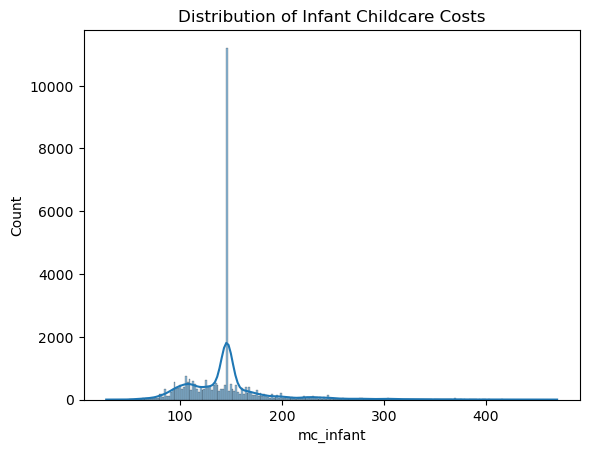

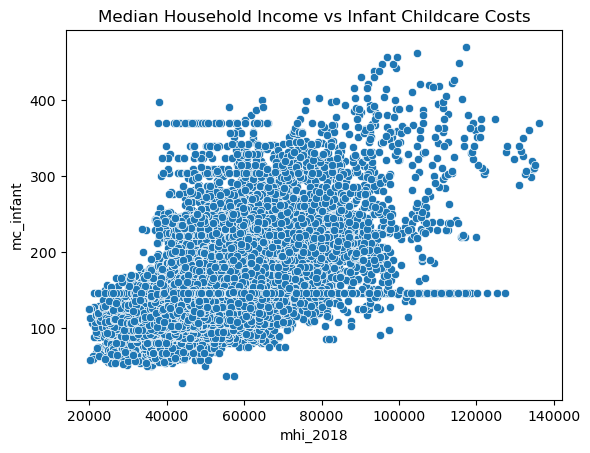

                  mcsa      mfccsa      mhi_2018
state_name                                      
Alabama      92.246662   89.283555  41481.139335
Alaska      106.862464   96.076439  67993.618679
Arizona     119.649152  101.800485  47326.595030
Arkansas     92.847471   86.547954  39630.160509
California  159.427571  137.847085  62078.513621


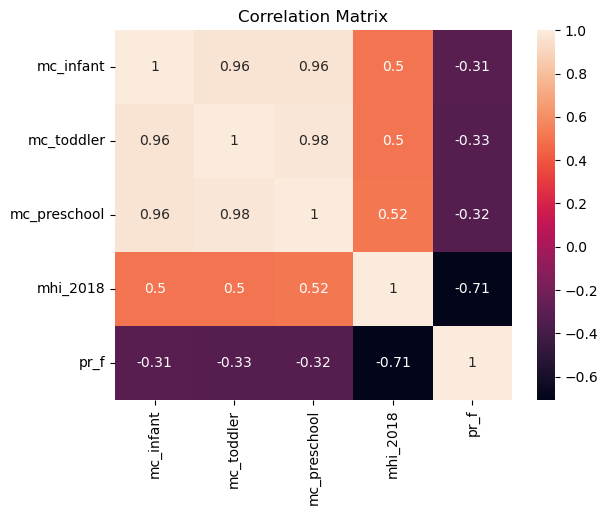

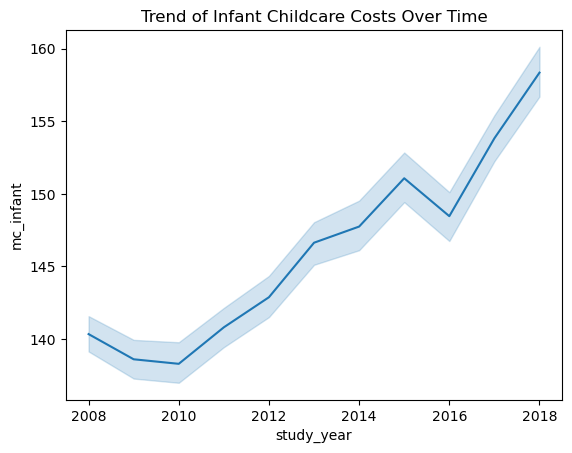

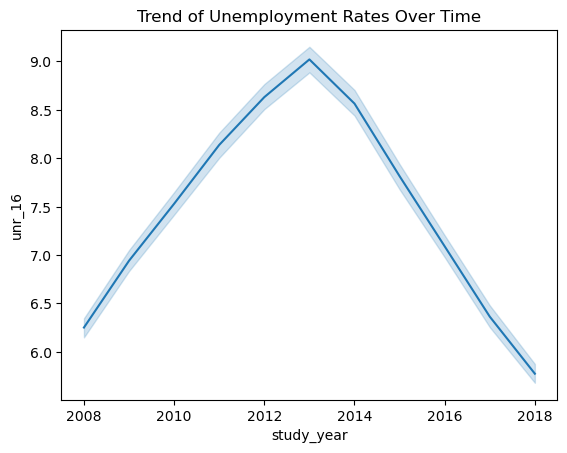

In [10]:
# Basic statistics
print(imputed_df.describe())

# Distribution of childcare costs
sns.histplot(imputed_df['mc_infant'], kde=True)
plt.title('Distribution of Infant Childcare Costs')
plt.show()

# Median income vs. childcare costs
sns.scatterplot(x='mhi_2018', y='mc_infant', data=imputed_df)
plt.title('Median Household Income vs Infant Childcare Costs')
plt.show()

# Group by state and calculate averages
state_averages = imputed_df.groupby('state_name')[['mcsa', 'mfccsa', 'mhi_2018']].mean()
print(state_averages.head())

# Correlation matrix
sns.heatmap(imputed_df[['mc_infant', 'mc_toddler', 'mc_preschool', 'mhi_2018', 'pr_f']].corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

# Trends over time
sns.lineplot(x='study_year', y='mc_infant', data=imputed_df)
plt.title('Trend of Infant Childcare Costs Over Time')
plt.show()

sns.lineplot(x='study_year', y='unr_16', data=imputed_df)
plt.title('Trend of Unemployment Rates Over Time')
plt.show()

## Regression Analysis

### Context
This regression analysis aims to uncover the intricacies behind childcare costs variability, delving into a variety of non-categorical data points from an imputed dataset. The goal was to determine the extent to which these costs can be explained numerically without resorting to categorical variables such as state or county names.

### Process
- **Data Preparation**: From the `imputed_df`, all categorical variables were excluded to focus solely on numeric predictors.
- **Feature Selection**: Initial feature selection was performed using Recursive Feature Elimination with Cross-Validation (`RFECV`). This selected 46 variables, but the adjusted R-squared was only marginally satisfactory at 0.294.
- **Refinement**: To streamline the model, Sequential Feature Selector (`SFS`) was utilized with a cap of 10 features, resulting in an adjusted R-squared of 0.264 — a comparable fit with significantly fewer predictors.
- **Selected Features**: The final model incorporated the following features: `study_year`, `munr_20to64`, `mhi_2018`, `mme_2018`, `one_race_i`, `h_under6_both_work`, `h_under6_f_work`, `emp_service`, `femp_n`, and `emp_p`.

### Regression Results
A summary of the OLS regression is provided below. The model explains approximately 26.4% of the variability in childcare costs, with significant predictors contributing to the model's predictive power. Notably, the `study_year` shows a positive coefficient, indicating an increase in childcare costs over time, aligning with inflation and cost of living increases. Employment-related features also play a significant role, reflecting the interplay between work participation and childcare needs.

**Key Takeaways:**
- The negative coefficient for `one_race_i` suggests that an increase in the percentage of individuals identifying with a single race may be associated with lower childcare costs.
- Employment in the service sector (`emp_service`) and female employment (`femp_n`) are positively associated with childcare costs, possibly indicating higher demand for childcare services in regions with higher employment rates.

**Caveats:**
- A considerable condition number hints at potential multicollinearity issues, suggesting that some features may be providing overlapping information.
- The Durbin-Watson statistic is lower than 1, indicating potential autocorrelation in the residuals, which should be addressed in further analyses.

In [11]:
numeric_imputed_df = imputed_df.select_dtypes(include=[np.number])
numeric_imputed_df

,county_fips_code,study_year,unr_16,funr_16,munr_16,unr_20to64,funr_20to64,munr_20to64,flfpr_20to64,flfpr_20to64_under6,flfpr_20to64_6to17,flfpr_20to64_under6_6to17,mlfpr_20to64,pr_f,pr_p,mhi_2018,me_2018,fme_2018,mme_2018,total_pop,one_race,one_race_w,one_race_b,one_race_i,one_race_a,one_race_h,one_race_other,two_races,hispanic,households,h_under6_both_work,h_under6_f_work,h_under6_m_work,h_under6_single_m,h_6to17_both_work,h_6to17_fwork,h_6to17_mwork,h_6to17_single_m,emp_m,memp_m,femp_m,emp_service,memp_service,femp_service,emp_sales,memp_sales,femp_sales,emp_n,memp_n,femp_n,emp_p,memp_p,femp_p,mcsa,mfccsa,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool
0,1001,2008,5.42,4.41,6.32,4.6,3.5,5.6,68.9,66.9,79.59,60.81,84.0,8.5,11.5,58462.55,32710.60,25156.25,41436.80,49744,98.1,78.9,17.7,0.4,0.4,0.0,0.7,1.9,1.8,18373,1543,970,22,995.0,4900,1308,114,1966.0,27.40,24.41,30.68,17.06,15.53,18.75,29.11,15.97,43.52,13.21,22.54,2.99,13.22,21.55,4.07,80.92,81.40,104.95,104.95,85.92,83.45,83.45,81.40
1,1001,2009,5.93,5.72,6.11,4.8,4.6,5.0,70.8,63.7,78.41,59.91,86.2,7.5,10.3,60211.71,34688.16,26852.67,43865.64,49584,98.6,79.1,17.9,0.4,0.6,0.0,0.7,1.4,2.0,18288,1475,964,16,1099.0,5028,1519,92,2305.0,29.54,26.07,33.40,15.81,14.16,17.64,28.75,17.51,41.25,11.89,20.30,2.52,14.02,21.96,5.19,83.42,85.68,105.11,105.11,87.59,87.39,87.39,85.68
2,1001,2010,6.21,5.57,6.78,5.1,4.6,5.6,71.3,67.0,78.15,59.71,85.8,7.5,10.6,61775.80,34740.84,27391.08,46155.24,53155,98.5,79.1,17.9,0.3,0.7,0.0,0.6,1.5,2.3,19718,1569,1009,16,1110.0,5472,1541,113,2377.0,29.33,25.94,33.06,16.92,15.09,18.93,29.07,17.82,41.43,11.57,19.86,2.45,13.11,21.28,4.13,85.92,89.96,105.28,105.28,89.26,91.33,91.33,89.96
3,1001,2011,7.55,8.13,7.03,6.2,6.3,6.1,70.2,66.5,77.62,59.31,85.7,7.4,10.9,60366.88,34564.32,26727.68,45333.12,53944,98.5,78.9,18.1,0.2,0.7,0.0,0.5,1.5,2.4,19998,1695,1060,106,1030.0,5065,1965,246,2299.0,31.17,26.97,35.96,16.18,14.21,18.42,27.56,17.74,38.76,10.72,18.28,2.09,14.38,22.80,4.77,88.43,94.25,105.45,105.45,90.93,95.28,95.28,94.25
4,1001,2012,8.60,8.88,8.29,6.7,6.4,7.0,70.6,67.1,76.31,58.30,85.7,7.4,11.6,59150.30,34327.70,27967.50,44276.10,54590,98.5,78.9,18.1,0.3,0.8,0.0,0.4,1.5,2.4,19934,1714,938,120,1095.0,4608,1963,284,2644.0,32.13,28.59,36.09,16.09,14.71,17.63,28.39,17.79,40.26,9.02,16.03,1.19,14.37,22.88,4.84,90.93,98.53,105.61,105.61,92.60,99.22,99.22,98.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34562,56045,2014,3.60,5.36,2.28,2.4,4.8,0.6,75.9,74.8,77.38,48.93,78.4,9.0,12.4,57155.20,38797.06,23554.26,53898.88,7135,98.4,93.4,0.2,0.5,1.8,0.0,2.5,1.6,3.7,2996,303,102,0,90.0,428,242,0,173.0,30.63,30.24,31.17,16.31,7.80,28.04,15.08,5.52,28.25,21.75,32.89,6.41,16.23,23.55,6.13,91.14,112.94,147.36,120.38,123.99,110.71,110.71,111.47
34563,56045,2015,5.16,7.86,3.16,4.2,7.6,1.6,73.2,82.0,76.70,48.50,78.4,10.8,14.1,61202.28,41185.24,23912.54,56334.76,7152,96.7,94.7,0.2,1.2,0.5,0.0,0.1,3.3,3.3,2986,315,160,0,45.0,403,232,0,142.0,32.07,28.94,36.49,12.59,4.34,24.28,14.06,5.51,26.16,22.67,33.95,6.72,18.61,27.26,6.36,94.76,110.89,140.36,118.77,118.77,110.89,110.89,110.89
34564,56045,2016,3.61,4.67,2.79,3.4,4.5,2.6,69.7,68.1,78.50,53.80,75.3,13.3,14.7,58422.00,37423.05,22159.20,52897.95,7175,98.6,93.2,0.3,0.1,5.0,0.0,0.0,1.4,1.0,3134,303,130,0,43.0,318,319,0,230.0,32.90,31.99,34.10,15.11,4.89,28.57,16.47,7.97,27.66,18.67,30.61,2.94,16.86,24.55,6.72,98.38,108.85,133.37,117.16,113.55,114.10,111.07,110.31
34565,56045,2017,2.24,2.64,1.95,2.3,2.8,2.0,71.4,63.6,85.10,59.20,76.8,11.2,14.4,61393.15,37266.43,22621.89,53241.73,7117,97.9,93.0,0.5,0.1,4.3,0.0,0.0,2.1,1.4,3182,288,119,0,62.0,384,243,0,198.0,31.96,27.87,37.54,15.03,7.22,25.68,15.82,6.66,28.31,17.93,27.98,4.23,19.25,30.26,4.23,102.01,106.81,126.38,115.55,108.32,117.30,111.26,109.74


Childcare Affordability and Employment Rates:
Study: Investigate the relationship between childcare costs and employment rates, particularly for households with young children.

In [12]:
import statsmodels.api as sm

# List of columns to use as independent variables (features)
feature_cols = [
    'flfpr_20to64_under6'
]


target_col = 'mcsa'

# Drop rows with any NaN values in the specified columns
df_clean = imputed_df.dropna(subset=feature_cols + [target_col])

# Define features X and target y
X = df_clean[feature_cols]
y = df_clean[target_col]

# Add a constant to the model (the intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# View the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   mcsa   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     218.1
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           3.34e-49
Time:                        01:52:36   Log-Likelihood:            -1.6483e+05
No. Observations:               34565   AIC:                         3.297e+05
Df Residuals:                   34563   BIC:                         3.297e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  88.0233    

In [13]:
numeric_imputed_df = numeric_imputed_df[~numeric_imputed_df.isnull().any(axis=1)]
numeric_imputed_df

X = numeric_imputed_df.drop(['mcsa', 'mfccsa','mc_infant', 'mc_toddler', 'mc_preschool', 'mfcc_infant', 'mfcc_toddler', 'mfcc_preschool' ], axis=1)
y = numeric_imputed_df['mcsa']

In [14]:
# Initialize the model
model = LinearRegression()

# Initialize RFECV
selector = RFECV(estimator=model, step=1, cv=KFold(10), scoring='r2')

# Fit RFECV
selector = selector.fit(X, y)

# Transform X to the selected features
X_selected = selector.transform(X)

# Fit the model using the selected features
model.fit(X_selected, y)

# Print the optimal number of features
print('Optimal number of features: {}'.format(selector.n_features_))

# Get the ranking of the features
ranking = selector.ranking_

# Get the mask of selected features
selected_features = pd.Series(selector.support_, index=X.columns)

# Print which features were selected
print(selected_features[selected_features].index.tolist())

Optimal number of features: 46
['study_year', 'unr_16', 'funr_16', 'munr_16', 'unr_20to64', 'funr_20to64', 'munr_20to64', 'flfpr_20to64', 'flfpr_20to64_under6', 'flfpr_20to64_6to17', 'flfpr_20to64_under6_6to17', 'mlfpr_20to64', 'pr_f', 'pr_p', 'mhi_2018', 'fme_2018', 'one_race', 'one_race_w', 'one_race_b', 'one_race_i', 'one_race_a', 'one_race_h', 'one_race_other', 'two_races', 'hispanic', 'h_under6_both_work', 'h_under6_f_work', 'h_under6_single_m', 'h_6to17_fwork', 'h_6to17_mwork', 'h_6to17_single_m', 'emp_m', 'memp_m', 'femp_m', 'emp_service', 'memp_service', 'femp_service', 'emp_sales', 'memp_sales', 'femp_sales', 'emp_n', 'memp_n', 'femp_n', 'emp_p', 'memp_p', 'femp_p']


In [15]:
# List of columns to use as independent variables (features)
feature_cols = selected_features[selected_features].index.tolist()
X_optimized = X[feature_cols]

# Add a constant to the model (the intercept)
X_optimized = sm.add_constant(X_optimized)

# Fit the regression model
model = sm.OLS(y, X_optimized).fit()

# View the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   mcsa   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     312.6
Date:                Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:52:50   Log-Likelihood:            -1.5892e+05
No. Observations:               34565   AIC:                         3.179e+05
Df Residuals:                   34518   BIC:                         3.183e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [16]:
# Initialize the model
model = LinearRegression()

# Initialize Sequential Feature Selector with a maximum of 10 features
sfs = SFS(model, 
          k_features=(1, 10),  # This allows for any number of features between 1 and 10
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=5)

# Fit SFS
sfs.fit(X, y)

# Get the selected feature names
selected_features_sfs = X.columns[list(sfs.k_feature_idx_)]

print(f'Selected features: {selected_features_sfs}')

Selected features: Index(['study_year', 'munr_20to64', 'mhi_2018', 'mme_2018', 'one_race_i',
       'h_under6_both_work', 'h_under6_f_work', 'emp_service', 'femp_n',
       'emp_p'],
      dtype='object')


In [17]:
# List of columns to use as independent variables (features)
feature_cols = selected_features_sfs.to_list()

# Drop rows with any NaN values in the specified columns
X_optimized = X[feature_cols]

# Add a constant to the model (the intercept)
X_optimized = sm.add_constant(X_optimized)

# Fit the regression model
model = sm.OLS(y, X_optimized).fit()

# View the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   mcsa   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     1256.
Date:                Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:53:04   Log-Likelihood:            -1.5958e+05
No. Observations:               34565   AIC:                         3.192e+05
Df Residuals:                   34554   BIC:                         3.193e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2738.1724     84

Adjusted R-squared: The value is 0.267, indicating that approximately 26.7% of the variability in the dependent variable is explained by the model. This is a moderate amount, suggesting that the model has some predictive power, but there is still a large proportion of the variability that is unexplained by the model.

one_race_i, h_under6_both_work, h_under6_f_work, emp_service, femp_n, emp_p: All these variables have significant p-values indicating that they are statistically significant predictors in the model. The signs of their coefficients suggest their direction of association with childcare costs.
F-statistic: The F-statistic is large, and the p-value is less than 0.05, indicating that the overall model is statistically significant.


### Real-world Interpretation:

- The positive coefficient for study_year might indicate that over time there is an increase in the dependent variable, which could be something like employment rates or income levels (depending on what mcsa represents).
- The positive coefficient for munr_20to64 suggests that higher male unemployment rates in the age group 20-64 are associated with an increase in childcare costs.
- The negative coefficient for mme_2018 suggests that as male median earnings increase, childcare costs decrease.
- Other variables like one_race_i and h_under6_both_work show significant associations, which could indicate demographic and socioeconomic factors playing a role in childcare costs.
- The presence of autocorrelation and multicollinearity suggests that the results should be interpreted with caution, as these statistical issues can affect the reliability and validity of the regression model.

## Cluster Analysis

In this part of the study, I wanted to focus on understanding the demographic and socio-economic factors influencing childcare costs across different regions. To achieve this, I used K-Means clustering, a powerful unsupervised machine learning technique that allowed me to group similar counties based on selected features such as demographics, household composition, and employment sectors.

### Elbow Method
I employed the elbow method to determine the optimal number of clusters. This method calculates the within-cluster sum of squares (WCSS) for a range of cluster numbers and identifies a 'knee' in the graph. The elbow, or knee, suggests the point where adding more clusters does not significantly improve the fitting of the model. For our analysis, the elbow method indicated that three clusters would provide a meaningful segmentation without overfitting our data.

### Cluster Characteristics
The resulting clusters can be summarized as follows:

- **Cluster 0:** Characterized by higher median household incomes and childcare costs, possibly indicative of more affluent areas where a higher cost of living aligns with higher incomes.

- **Cluster 1:** Represents counties with lower median household incomes and childcare costs, suggesting areas with a potentially lower cost of living or different economic profiles.

- **Cluster 2:** Distinguished by the highest unemployment rates and a high percentage of households with both parents working, likely reflecting areas where dual income is necessary, and economic challenges are more pronounced.

Each cluster provides a unique lens through which we can examine the intricate relationship between socio-economic factors and childcare costs.

In [18]:
cluster_cols = ['one_race_w', 'one_race_b', 'h_under6_single_m','one_race_i','one_race_a', 'one_race_h', 'two_races', 'hispanic', 'h_under6_both_work', 
'h_under6_f_work', 'h_under6_m_work', 'h_under6_single_m', 'h_6to17_both_work', 'h_6to17_fwork', 
'h_6to17_mwork', 'h_6to17_single_m', 'memp_m', 'femp_m', 'memp_service', 
'femp_service', 'memp_sales', 'femp_sales', 'memp_n', 'femp_n', 'memp_p', 'femp_p']

X_demographic = X[cluster_cols]
X_demographic

,one_race_w,one_race_b,h_under6_single_m,one_race_i,one_race_a,one_race_h,two_races,hispanic,h_under6_both_work,h_under6_f_work,h_under6_m_work,h_under6_single_m,h_6to17_both_work,h_6to17_fwork,h_6to17_mwork,h_6to17_single_m,memp_m,femp_m,memp_service,femp_service,memp_sales,femp_sales,memp_n,femp_n,memp_p,femp_p
0,78.9,17.7,995.0,0.4,0.4,0.0,1.9,1.8,1543,970,22,995.0,4900,1308,114,1966.0,24.41,30.68,15.53,18.75,15.97,43.52,22.54,2.99,21.55,4.07
1,79.1,17.9,1099.0,0.4,0.6,0.0,1.4,2.0,1475,964,16,1099.0,5028,1519,92,2305.0,26.07,33.40,14.16,17.64,17.51,41.25,20.30,2.52,21.96,5.19
2,79.1,17.9,1110.0,0.3,0.7,0.0,1.5,2.3,1569,1009,16,1110.0,5472,1541,113,2377.0,25.94,33.06,15.09,18.93,17.82,41.43,19.86,2.45,21.28,4.13
3,78.9,18.1,1030.0,0.2,0.7,0.0,1.5,2.4,1695,1060,106,1030.0,5065,1965,246,2299.0,26.97,35.96,14.21,18.42,17.74,38.76,18.28,2.09,22.80,4.77
4,78.9,18.1,1095.0,0.3,0.8,0.0,1.5,2.4,1714,938,120,1095.0,4608,1963,284,2644.0,28.59,36.09,14.71,17.63,17.79,40.26,16.03,1.19,22.88,4.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34562,93.4,0.2,90.0,0.5,1.8,0.0,1.6,3.7,303,102,0,90.0,428,242,0,173.0,30.24,31.17,7.80,28.04,5.52,28.25,32.89,6.41,23.55,6.13
34563,94.7,0.2,45.0,1.2,0.5,0.0,3.3,3.3,315,160,0,45.0,403,232,0,142.0,28.94,36.49,4.34,24.28,5.51,26.16,33.95,6.72,27.26,6.36
34564,93.2,0.3,43.0,0.1,5.0,0.0,1.4,1.0,303,130,0,43.0,318,319,0,230.0,31.99,34.10,4.89,28.57,7.97,27.66,30.61,2.94,24.55,6.72
34565,93.0,0.5,62.0,0.1,4.3,0.0,2.1,1.4,288,119,0,62.0,384,243,0,198.0,27.87,37.54,7.22,25.68,6.66,28.31,27.98,4.23,30.26,4.23


/opt/homebrew/anaconda3/envs/childcare_project/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/envs/childcare_project/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/envs/childcare_project/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/envs/childcare_project/lib/python3.11/site-packages/

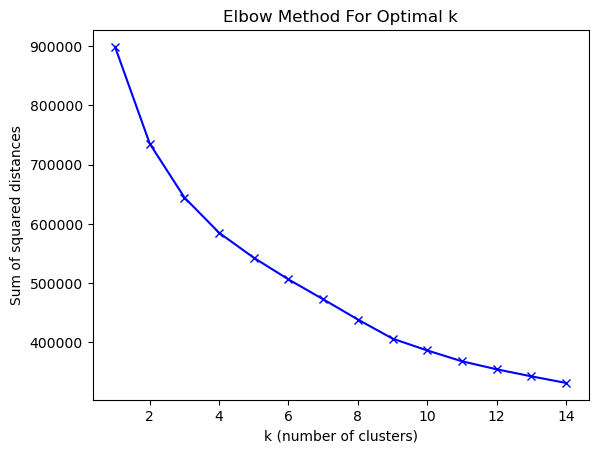

In [19]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_demographic)

# Calculate the sum of squared distances for different numbers of clusters
ssd = []  # sum of squared distances
K_range = range(1, 15)  # for example, testing 1 to 14 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    ssd.append(kmeans.inertia_)  # .inertia_ gives the sum of squared distances to the closest cluster center

# Plot the Elbow graph
plt.plot(K_range, ssd, 'bx-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [20]:
# Standardize the features (important for k-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_demographic)

# Choose the number of clusters and fit the model
kmeans = KMeans(n_clusters=3, random_state=7)
kmeans.fit(X_scaled)

# Attach the cluster labels to the original DataFrame
imputed_df['cluster_label'] = kmeans.labels_

# Now we can analyze how childcare costs differ across clusters
average_costs_per_cluster = imputed_df.groupby('cluster_label')[['mc_infant', 'mc_toddler', 'mc_preschool']].mean()
print(average_costs_per_cluster)


/opt/homebrew/anaconda3/envs/childcare_project/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                mc_infant  mc_toddler  mc_preschool
cluster_label                                      
0              195.976070  170.181280    157.183433
1              139.093988  125.008873    117.394083
2              208.994306  172.283606    163.252028


In [21]:
numeric_imputed_df = imputed_df.select_dtypes(include=[np.number])
cluster_profiles = numeric_imputed_df.groupby('cluster_label').mean()  # Or median(), min(), max()
display(cluster_profiles.transpose())

cluster_label,0,1,2
county_fips_code,28892.544687,30621.406904,2.415694e+04
study_year,2013.181728,2012.975890,2.013000e+03
unr_16,7.163141,7.497180,9.009318e+00
funr_16,6.862848,7.039741,8.978864e+00
munr_16,7.441805,7.909021,9.053409e+00
unr_20to64,6.525494,6.941564,8.326136e+00
funr_20to64,6.261715,6.500423,8.346591e+00
munr_20to64,6.771711,7.336282,8.331818e+00
flfpr_20to64,74.196219,69.539209,7.036591e+01
flfpr_20to64_under6,69.910772,68.705397,6.401364e+01


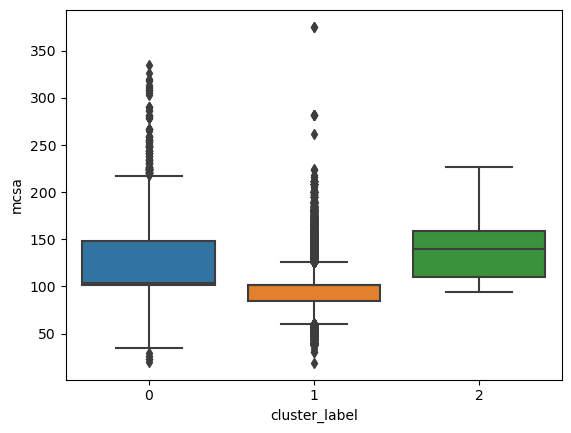

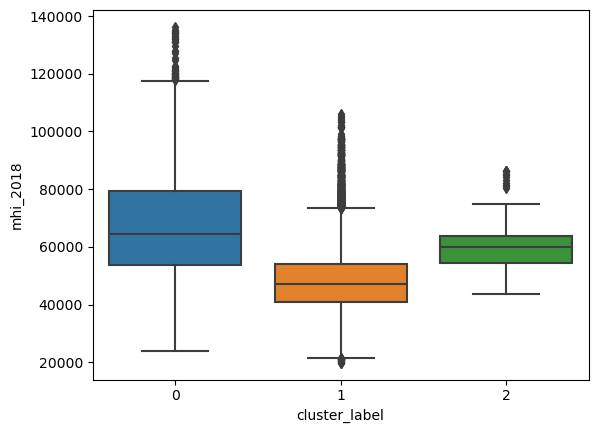

In [31]:
# Plotting the distribution of center-based childcare costs across the clusters
sns.boxplot(x='cluster_label', y='mcsa', data=numeric_imputed_df)
plt.show()

# Plotting the distribution of household income (adjusted for 2018) across the clusters
sns.boxplot(x='cluster_label', y='mhi_2018', data=numeric_imputed_df)
plt.show()

### ANOVA Analysis
Following clustering, I employed ANOVA to test the hypothesis that the clusters differ significantly in terms of childcare costs. The ANOVA results indicated a strong statistical significance, suggesting that the clusters are indeed distinct with respect to this critical variable.

### Real-World Implications and Value
The findings from our clustering and ANOVA analyses are not just numbers and statistics; they have tangible real-world implications:
- **Policy Development**: Our results can guide policymakers to identify regions that may benefit from targeted childcare subsidies or economic support, contributing to more equitable social policies.
- **Resource Allocation**: Non-profits and community organizations can allocate resources more effectively, ensuring that aid reaches those in the most need, as indicated by the distinct clusters.
- **Economic Insights**: For businesses, especially in the childcare industry, the cluster analysis can illuminate potential markets for expansion, where demand for affordable childcare is not currently met.
- **Societal Impact**: Raising awareness about the disparities in childcare costs can lead to a more informed public discourse, potentially catalyzing community-led initiatives to address the issue.
- **Academic and Research Value**: The insights serve as a foundation for further research into the socio-economic factors influencing childcare costs, which could be invaluable for academic scholars and researchers.

In [23]:
# ANOVA test for 'mcsa'
anova_results = f_oneway(
    numeric_imputed_df[numeric_imputed_df['cluster_label'] == 0]['mcsa'],
    numeric_imputed_df[numeric_imputed_df['cluster_label'] == 1]['mcsa'],
    numeric_imputed_df[numeric_imputed_df['cluster_label'] == 2]['mcsa'],
)

print(f"ANOVA results: F={anova_results.statistic}, p={anova_results.pvalue}")

ANOVA results: F=1986.3867331426425, p=0.0


In [24]:
# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(numeric_imputed_df['mcsa'], numeric_imputed_df['cluster_label'])

# Print the results
print(tukey_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     0      1 -27.1715   0.0 -28.2354 -26.1076   True
     0      2  16.3996   0.0  11.5137  21.2854   True
     1      2  43.5711   0.0  38.7748  48.3673   True
-----------------------------------------------------


I hope you enjoyed this study. If you'd like to take a look at more visualizations, you can view them in my Google Data Studio dashboard here: https://lookerstudio.google.com/reporting/c74a3017-3550-4804-b9d1-cf76a7890028

In [25]:
#imputed_df.to_csv('imputed_childcare_df.csv', index=False)